# Contour Maps

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapped
from mapped.density import GeoKernelDensity, plot_mesh_contour
mapped.__version__

'19.12.0'

Import some random example point data.

In [2]:
from mapped.example_data import mad_points
points = mad_points()
points.head()

,number,letter,geometry
0,52.064541,B,POINT (-9937504.906791614 5319115.428665807)
1,50.761888,A,POINT (-9954448.395076841 5315974.063502626)
2,55.079217,B,POINT (-9943478.867470412 5307611.28951565)
3,52.615496,A,POINT (-9936556.658328719 5318097.389932256)
5,51.080653,B,POINT (-9938781.95491216 5309253.875335691)


The class `GeoKernelDensity` wraps the more generic scikit-learn `KernelDensity`, providing some 
simplifying default options and features.

In [3]:
from mapped.density import GeoKernelDensity
gkde = GeoKernelDensity(bandwidth=0.00015).fit(points)

One handy feature is the ability to directly output contour plots.

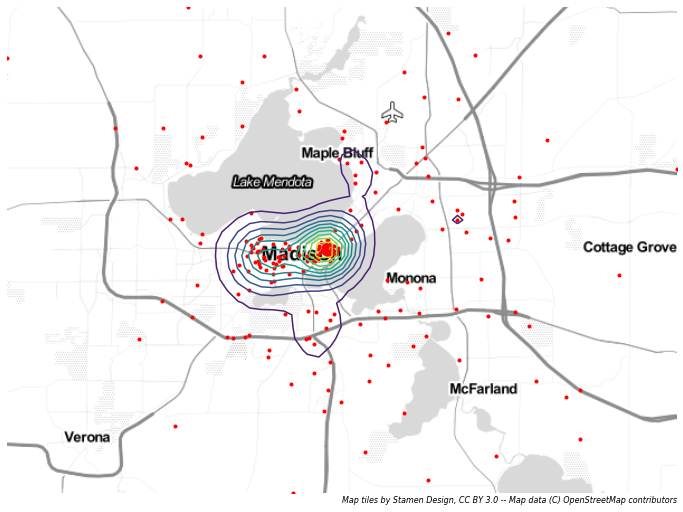

In [4]:
ax = gkde.contour(basemap='Stamen.TonerLite', figsize=(12,12), levels=10)
points.plot(color='red', marker='.', ax=ax );

The `multifit` fits seperate kernel densities on segments of the data defined by `groupby`.

In [5]:
gkde_m = GeoKernelDensity(bandwidth=0.00015).multifit(points, 'letter')

For example, the demo points contain two classes of point, 'A' and 'B'.

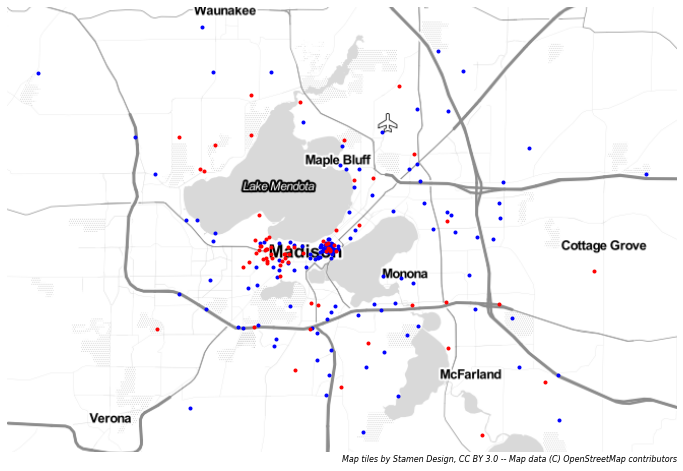

In [6]:
ax = points.query("letter=='A'").plot(color='blue', marker='.', basemap='Stamen.TonerLite', figsize=(12,12))
points.query("letter=='B'").plot(color='red', marker='.', ax=ax );

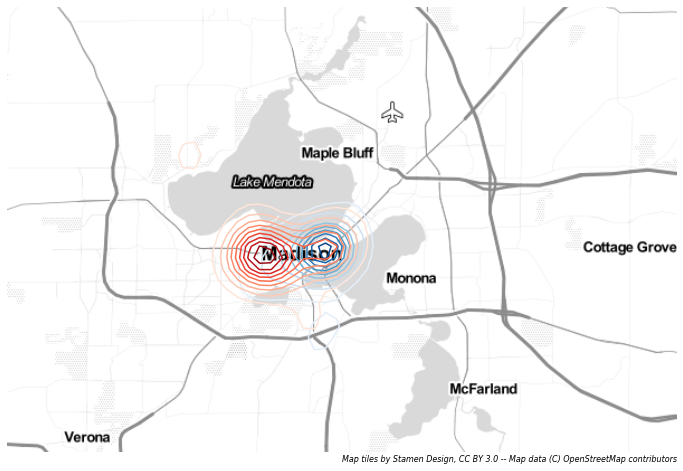

In [7]:
ax = gkde_m['A'].contour(basemap='Stamen.TonerLite', figsize=(12,12), levels=10, cmap='Blues');
gkde_m['B'].contour(ax=ax, figsize=(12,12), levels=10, cmap='Reds');

The red and blue contours on the plot above have different scales.  To 
harmonize the scales, we need to compute the levels explicitly and pass 
them to the function.  We can also smooth it out my increasing the resolution
from the  default (which is 100).

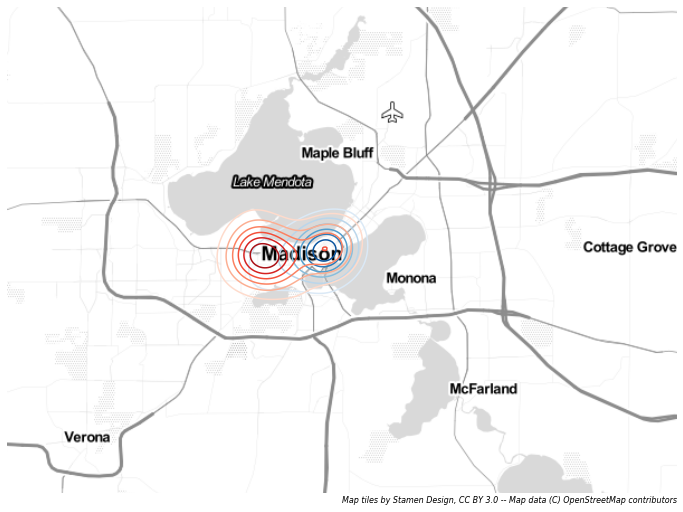

In [8]:
mesh = gkde_m.point_grid(resolution=300, bounds=points, total='TOT')
levels = np.linspace(0, max(mesh['A'].max(), mesh['B'].max()), 8)

ax = mesh.contour('A', basemap='Stamen.TonerLite', figsize=(12,12), levels=levels, cmap='Blues');
mesh.contour('B', ax=ax, figsize=(12,12), levels=levels, cmap='Reds');

We can mask out lakes if we have a the shape of the lakes from some data file.

In [9]:
import pickle
with open("dane_county_land.pkl", 'rb') as f:
    land = pickle.load(f)
    
land = gpd.GeoDataFrame(
    geometry=[land],
    crs = {'init': 'epsg:4326', 'no_defs': True},
).to_crs(mesh.crs)

In [10]:
mask = mesh.within(land.unary_union)

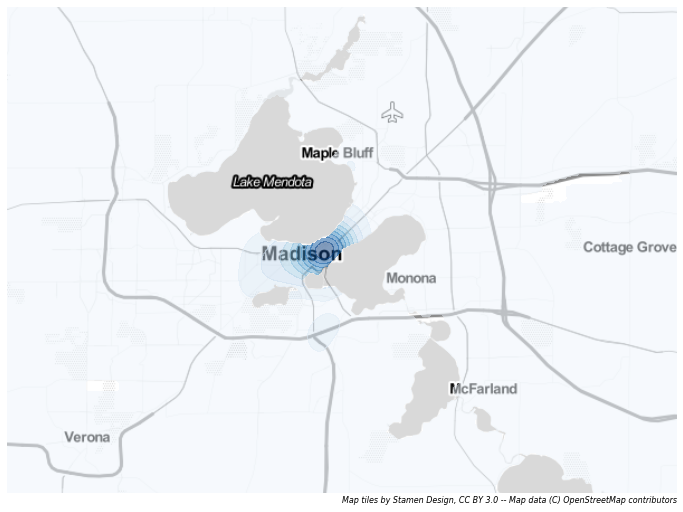

In [11]:
mesh.contour(
    'A', 
    filled=True, 
    alpha=0.5,
    cmap='Blues', 
    basemap='Stamen.TonerLite', 
    levels=10, 
    figsize=(12,12),
    mask=mask,
);

Plot the relative kernel density of A.

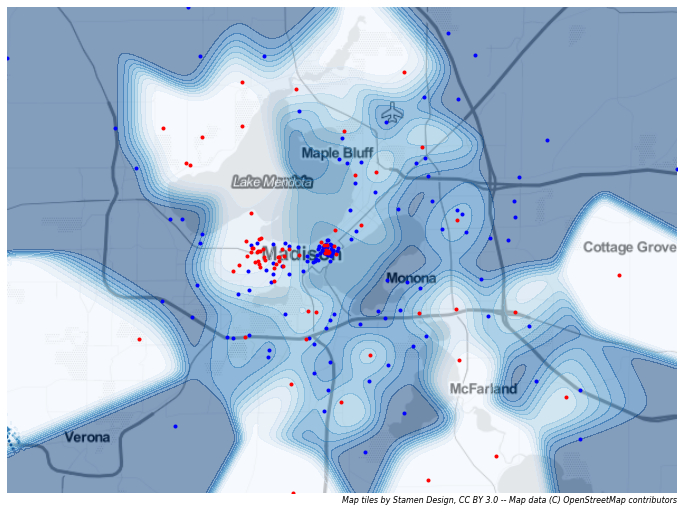

In [12]:
ax = mesh.contour(
    'A/TOT', 
    filled=True, 
    alpha=0.5,
    cmap='Blues', 
    basemap='Stamen.TonerLite', 
    levels=10, 
    figsize=(12,12),
)

# Also plot the source points by color.
ax = points.query("letter=='A'").plot(ax=ax, color='blue', marker='.')
ax = points.query("letter=='B'").plot(ax=ax, color='red', marker='.');

Plot the relative kernel density of B, masking lakes.

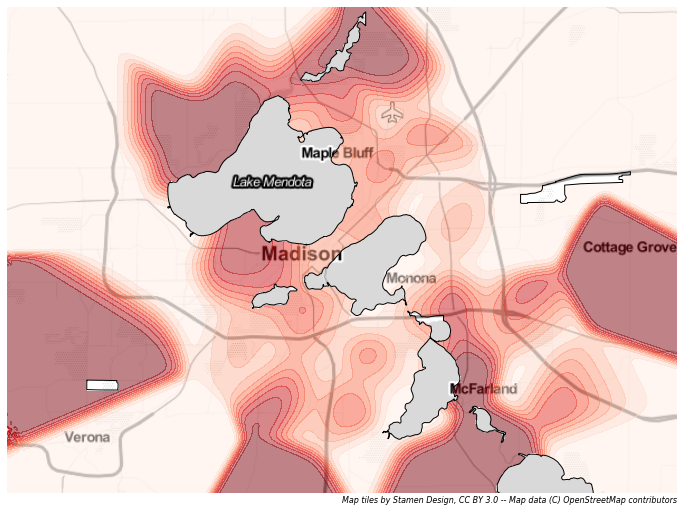

In [13]:
ax = plot_mesh_contour(
    mesh, 'B/TOT', 
    filled=True, 
    alpha=0.5,
    cmap='Reds', 
    basemap='Stamen.TonerLite', 
    levels=10, 
    mask=mask,
    figsize=(12,12),
)

# Draw a black border over lakeshores for a cleaner look.
land.plot(color="none", edgecolor="black", ax=ax);